In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt 

from src.features import build_features

import logging 
from pathlib import Path

import scipy
import pickle
import datetime
import numpy as np

logging.basicConfig(level=logging.INFO)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Build Features
Use the build_features functions to build dataset from database (usually takes ~1 min)

In [22]:
load_fresh_features = True

proj_path = Path().resolve().parents[1]
processed_path = proj_path / "data" / "processed"

if load_fresh_features:
    today = str(datetime.date.today())
    features, pipe = build_features.bag_of_words_tfid_norm()
    scipy.sparse.save_npz(file=str(processed_path / f"features_{today}.npz"), matrix=features)
    pipe_path = str(processed_path / f"pipe_{today}.pkl")
    with open(pipe_path, 'wb') as file:
        pickle.dump(pipe, file)
    print(f"Date: {today}")
else:
    features, pipe = build_features.load_saved_features(date="2021-03-07")

Date: 2021-03-23


# PCA
To visualize the clustering algorithms I'll use two or three principal components throughout this notebook.

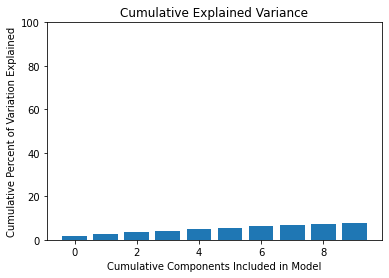

In [23]:
# initialize PCA:
# reduce features:
pca = PCA(n_components=10)
reduced_features = pca.fit_transform(features.toarray())

# display percent explained variance of the first ten components:
fig = plt.figure()
plt.bar(x=range(len(pca.explained_variance_ratio_)), height=np.cumsum(pca.explained_variance_ratio_)*100)
plt.ylim([0, 100])
plt.ylabel("Cumulative Percent of Variation Explained")
plt.xlabel("Cumulative Components Included in Model")
plt.title("Cumulative Explained Variance");

Unfortunately the first two components only seem to code for about 5% (if that) of the percent variation. This makes sense since the bog-of-words is massive, however this means that we cannot trust visual cluster, we'll need some empirical measure of clsuter goodness. 

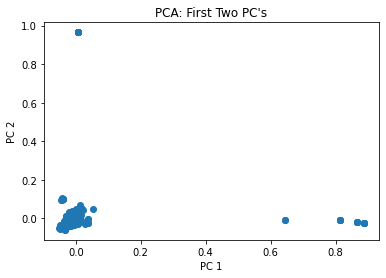

In [24]:
# scatterplot of first two PC's:
fig, ax = plt.subplots()
scatter = plt.scatter(reduced_features[:,0], reduced_features[:,1])
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA: First Two PC's");

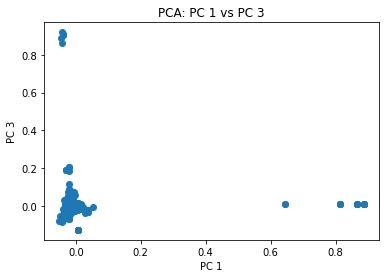

In [25]:
# scatterplot of PC 1 and PC 3:
fig, ax = plt.subplots()
scatter = plt.scatter(reduced_features[:,0], reduced_features[:,2])
plt.xlabel("PC 1")
plt.ylabel("PC 3")
plt.title("PCA: PC 1 vs PC 3");

PC 1 vs PC 3 seems to be very similar to PC1 vs PC2, so I think it'll be fairly reasonabl to just use these two in the rest of the notebook.

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


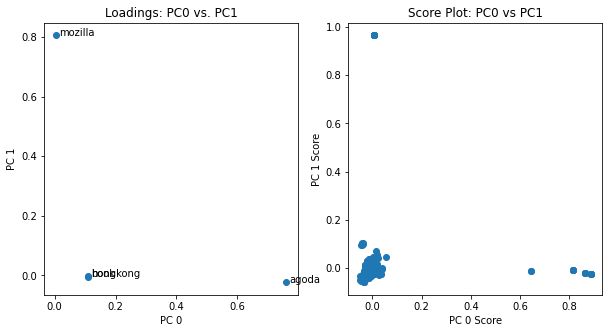

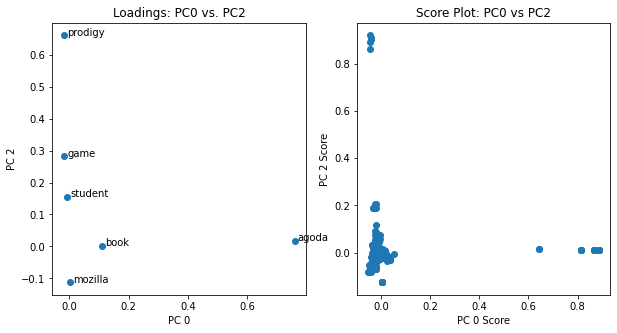

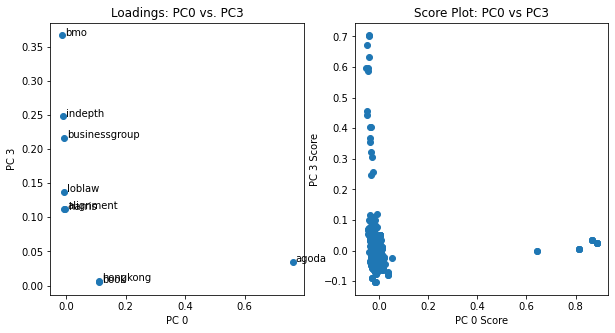

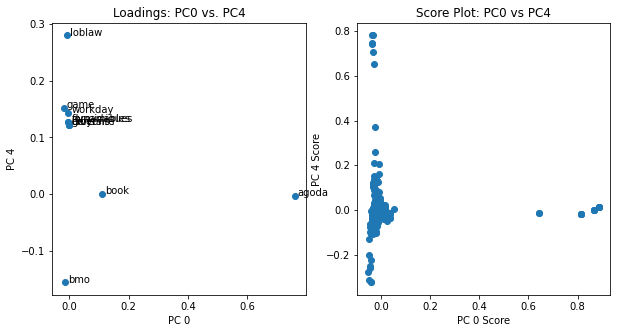

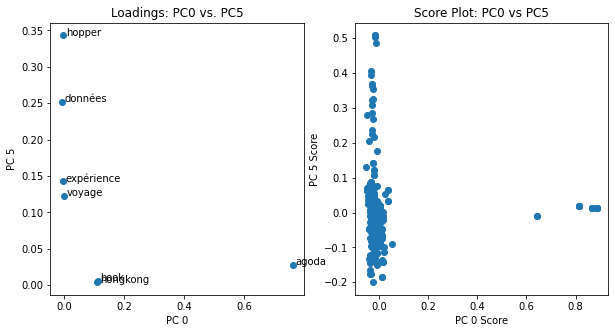

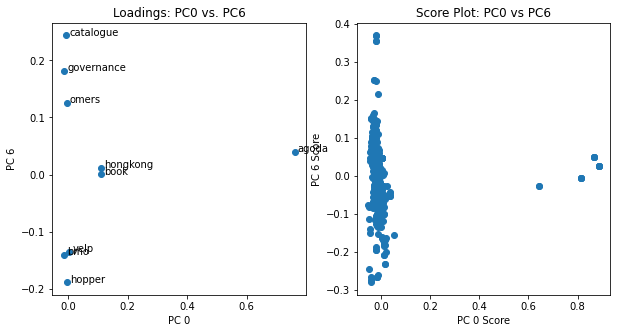

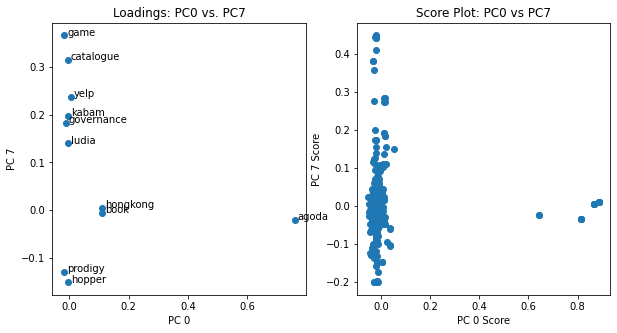

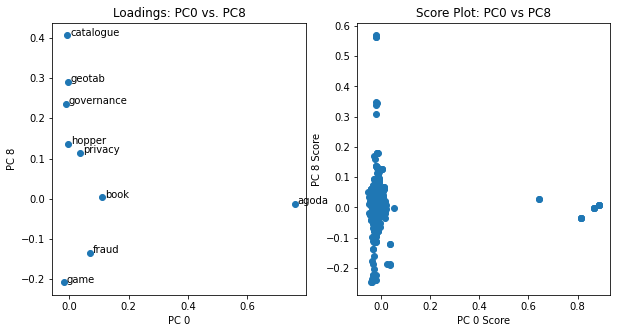

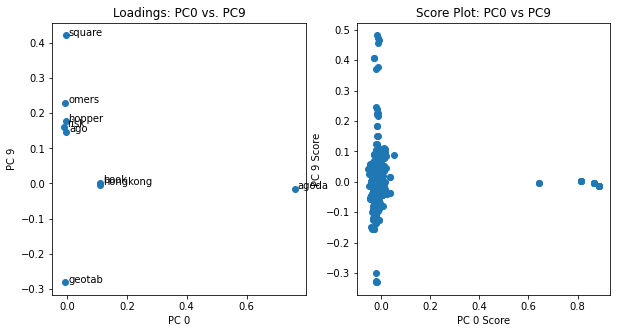

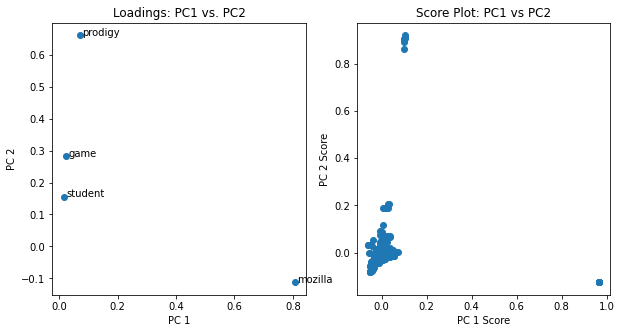

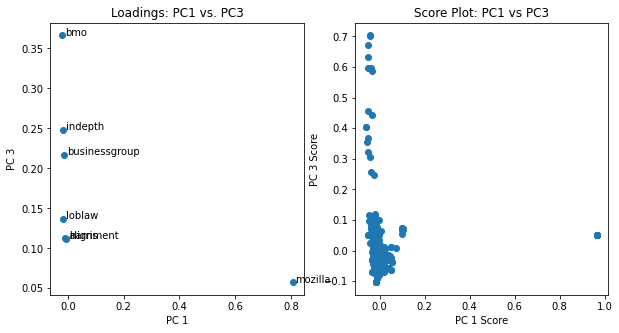

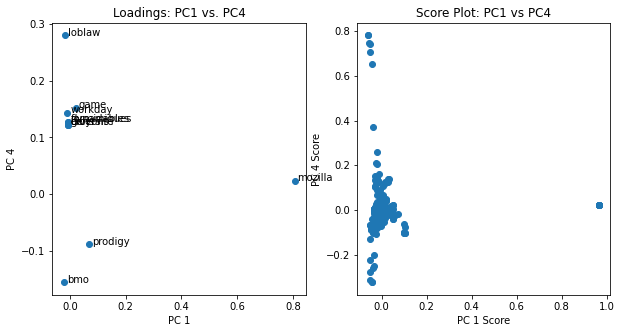

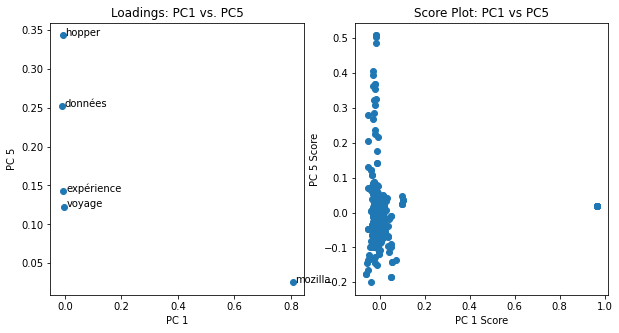

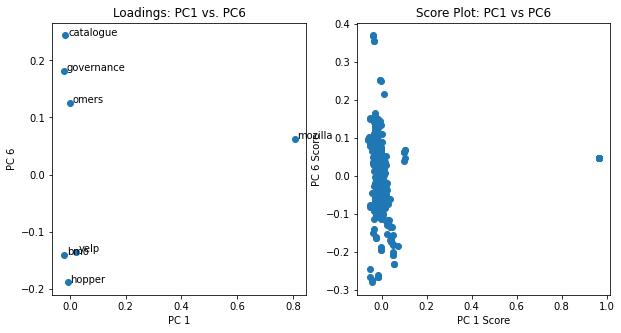

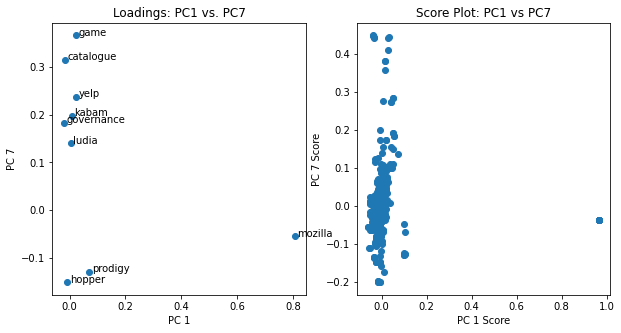

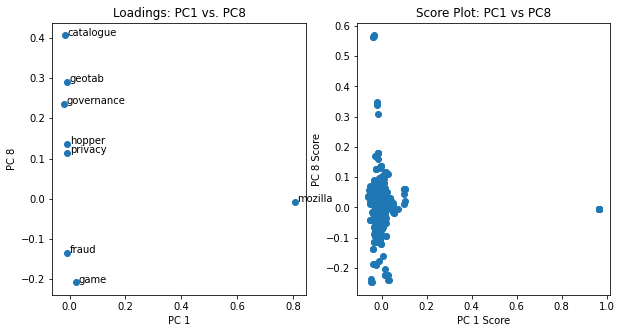

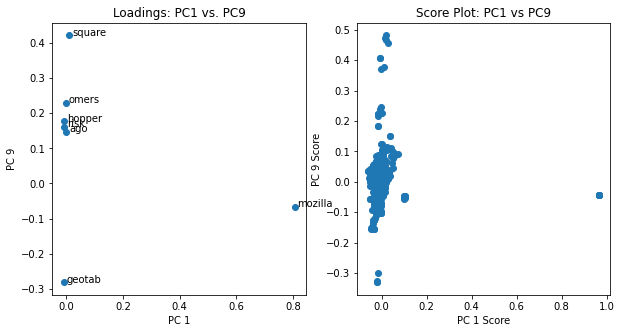

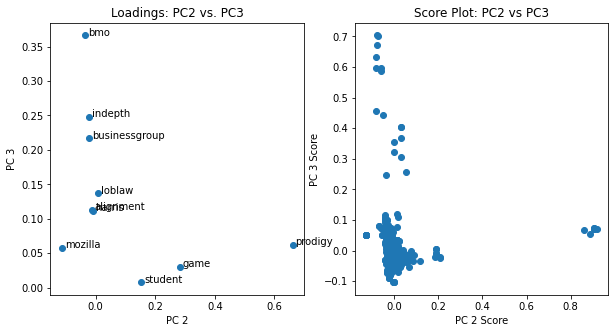

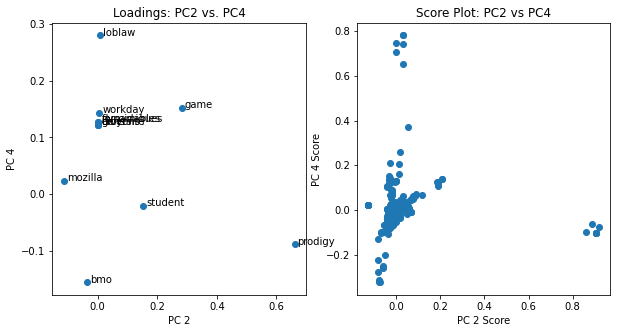

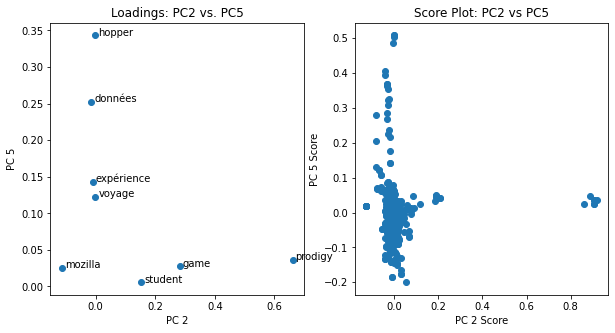

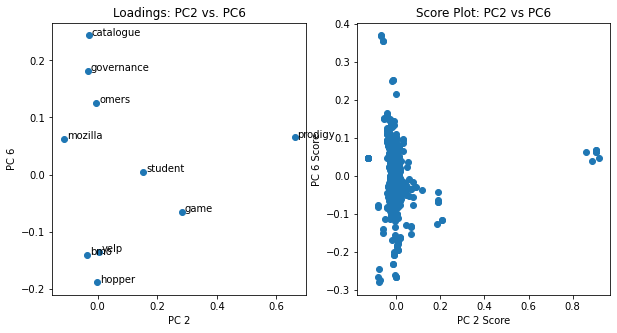

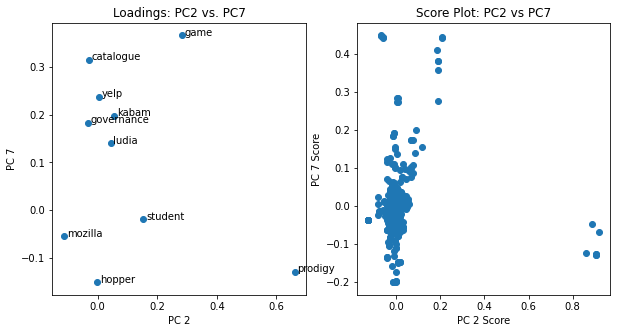

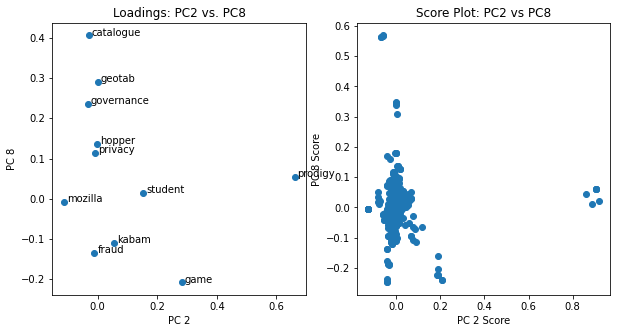

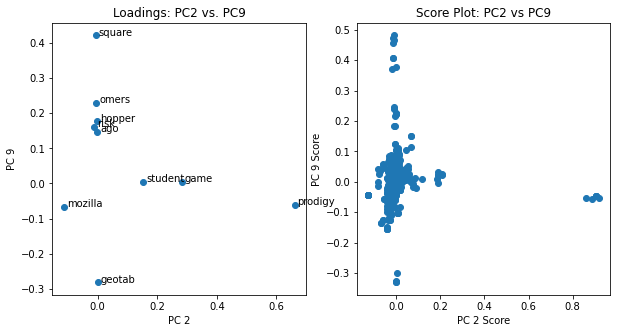

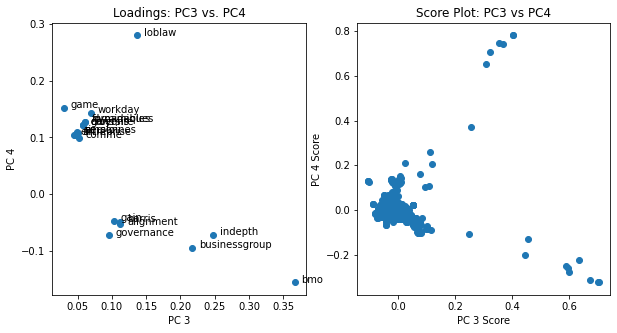

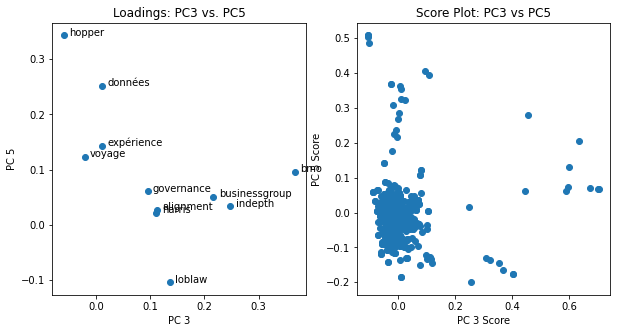

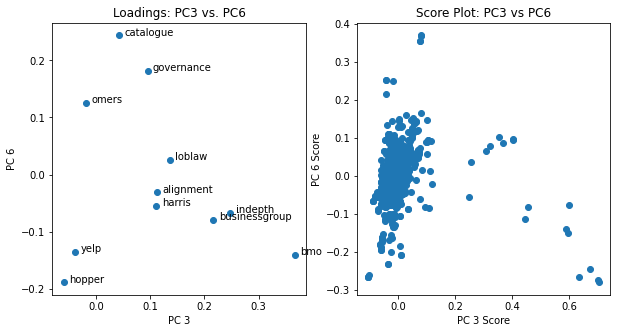

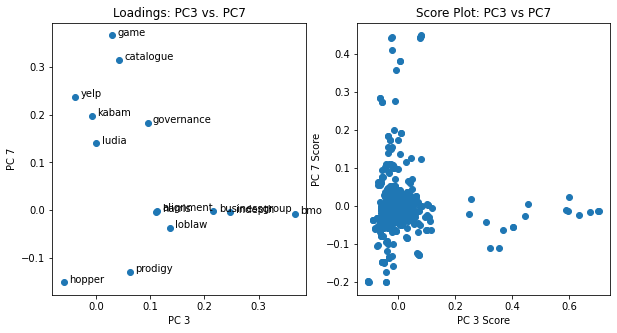

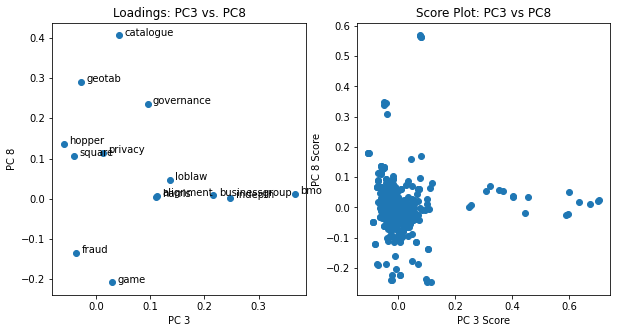

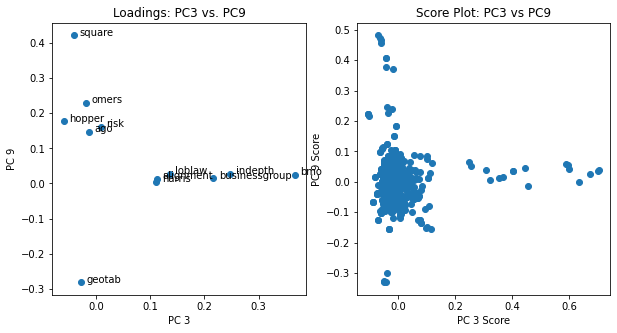

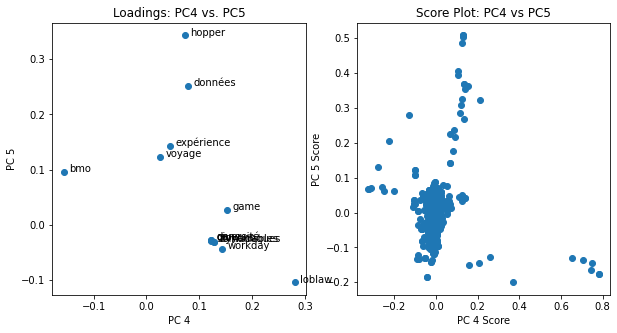

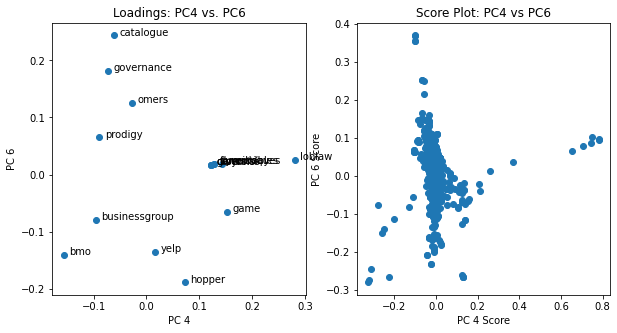

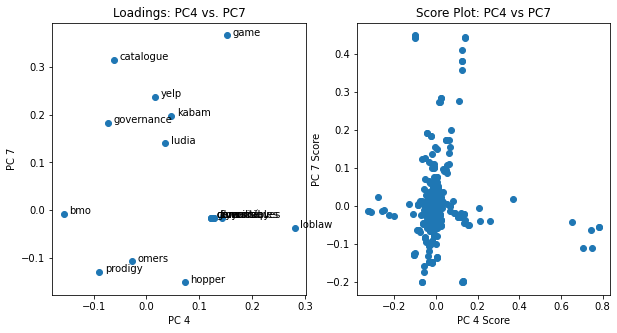

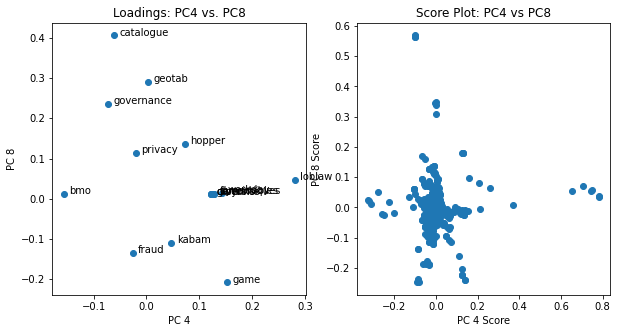

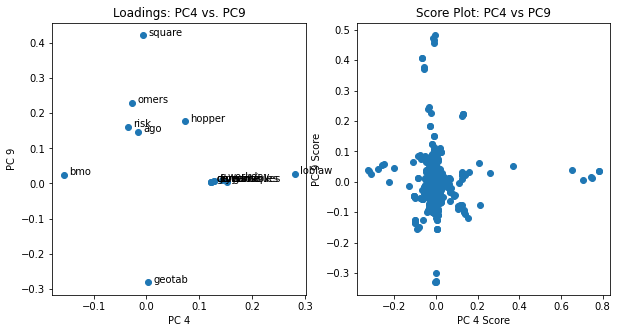

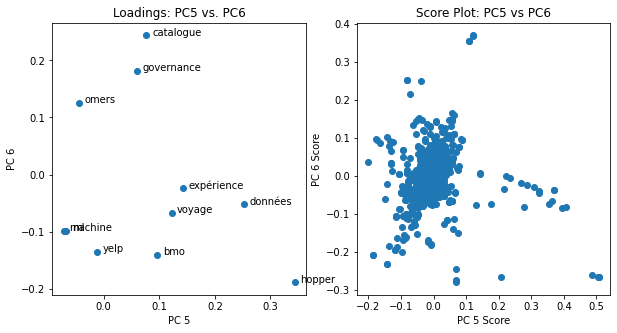

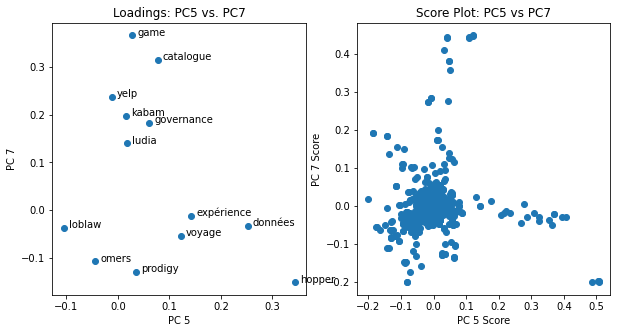

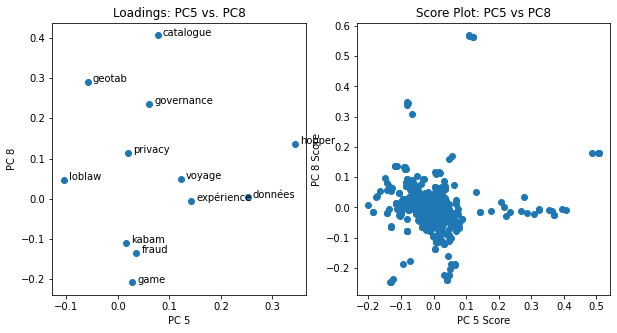

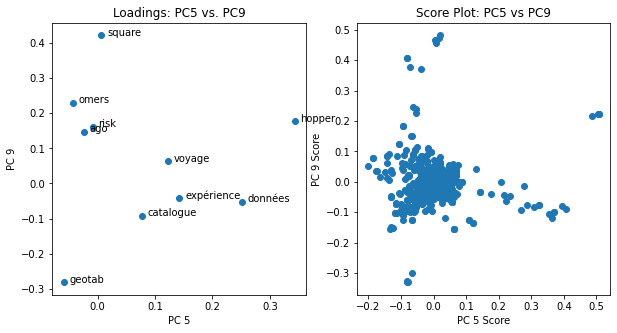

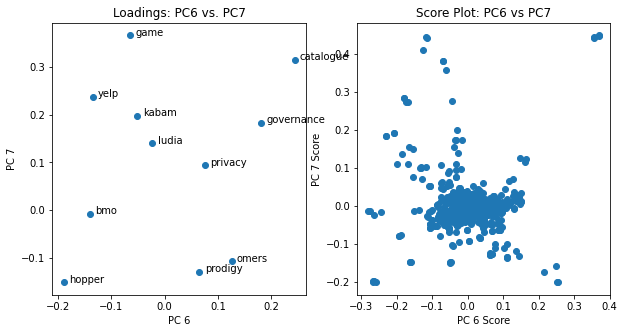

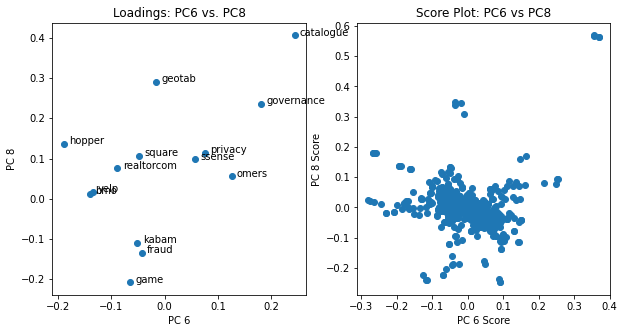

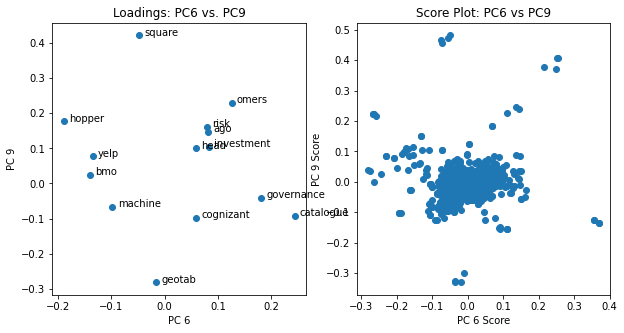

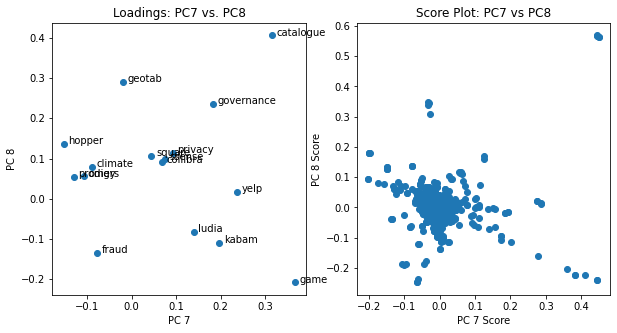

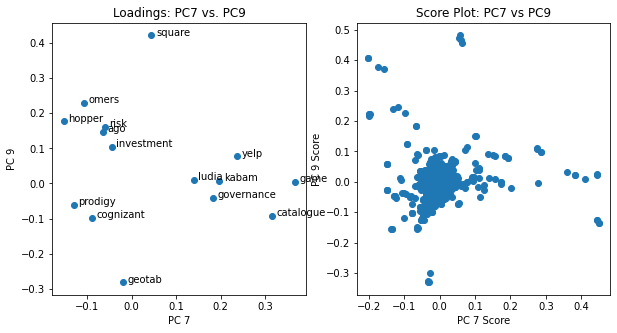

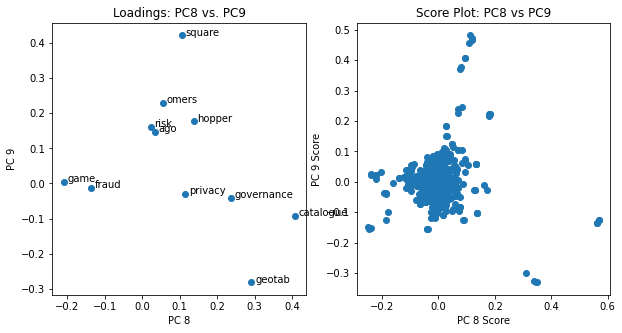

In [26]:
from operator import itemgetter
def plot_pca(pc_x, pc_y, threshold):
    """Plots the loadings and the score plot side by side
    
    pc_x : int
    pc_y : int
    threshold : float
    """
    fig = plt.figure(figsize=(10, 5))
    vocab = pipe.named_steps['tfidf_vec'][0].vocabulary_
    index = np.where((pca.components_[pc_x]**2 + pca.components_[pc_y]**2)**0.5 > threshold)[0]
    labels=itemgetter(*tuple(index))({v: i  for i, v in vocab.items()})

    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(
        x=pca.components_[pc_x][index],
        y=pca.components_[pc_y][index],
    )
    for word, i in zip(labels, index):
        x = pca.components_[pc_x][i]+0.01
        y = pca.components_[pc_y][i]
        ax.text(x, y, word)

    ax.set_xlabel(f"PC {pc_x}")
    ax.set_ylabel(f"PC {pc_y}")
    ax.set_title(f"Loadings: PC{pc_x} vs. PC{pc_y}");

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(reduced_features[:,pc_x], reduced_features[:,pc_y])
    ax2.set_xlabel(f"PC {pc_x} Score")
    ax2.set_ylabel(f"PC {pc_y} Score")
    ax2.set_title(f"Score Plot: PC{pc_x} vs PC{pc_y}");

# quick look at loadings:
n = 10
for x in range(n):
    for y in range(x+1, n):
        plot_pca(x, y, 0.11)

It looks like the first two components are not good at visualizing the differences between points. After looking at all the combinations of the first ten components I think the best view is using on of the following pairs:<br><br>

# Cluster Exploration

The dataset is made up of ~350 documents where each document is the job details section from LinkedIn and the keywords used to were either "Data Scientist" or "Data Analyst". As a result we can expect that many of the descriptions will be similar, however it is common knowledge that "Data Scientist" is poorly defined in the industry, and therefore we're expected a few different clusters of descriptions. We expect one cluster to be finance, another to be in technology, insurance, etc. 

While there isn't any way to confirm our hypthesis yet, the first step will be to optimize a clustering algorithm, which is the purpose of this notebook.

The basic process I follow is:
- initialize a cluster algo
- optimize some basic parameters
- move onto next
- summarize at end

I use the silhouette score to measure cluster goodness. The Silhouette Coefficient is calculated using the mean intra-cluster distance (`a`) and the mean nearest-cluster distance (`b`) for each sample. The Silhouette Coefficient for a sample is `(b - a) / max(a, b)`. To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is `2 <= n_labels <= n_samples - 1`.

In [27]:
import time
def cluster_report(cls):
    t0 = time.time()
    print(cls)
    cls.fit(features.toarray())
    fig, ax = plt.subplots()
    scatter = plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.labels_)

    legend1 = ax.legend(*scatter.legend_elements(),
                        title="Classes")
    ax.add_artist(legend1)

    if len(set(cls.labels_)) > 1:
        sil_score = silhouette_score(features.toarray(), labels=cls.labels_)
        plt.title(f"Silhouette Score = {np.round(sil_score, 4)}")
    else:
        plt.title("Only one cluster")
    plt.show()
    print(f"Clustering trained in {time.time() - t0} seconds")
    print('------------------------------------------------------\n')

# Clustering Algorthims

In [28]:
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, AgglomerativeClustering, DBSCAN, MiniBatchKMeans

## KMeans
I'll start with KMeans since it's so well known and there are few parameters to optimize.

KMeans(n_clusters=3, random_state=1)


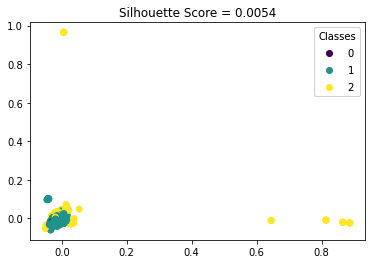

Clustering trained in 2.0301876068115234 seconds
------------------------------------------------------



In [29]:
random_state = 1
kmeans = KMeans(n_clusters=3, random_state=random_state)


kmeans.fit(features)
cluster_report(kmeans)

# Train and Save

KMeans(n_clusters=3)


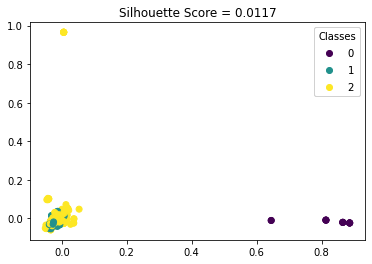

Clustering trained in 2.049736976623535 seconds
------------------------------------------------------

MeanShift()


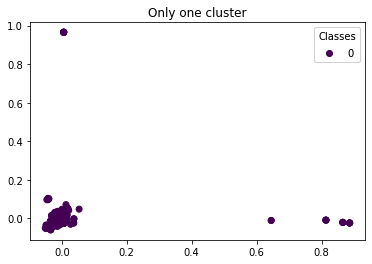

Clustering trained in 94.09490418434143 seconds
------------------------------------------------------

AffinityPropagation(damping=0.6)


c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning


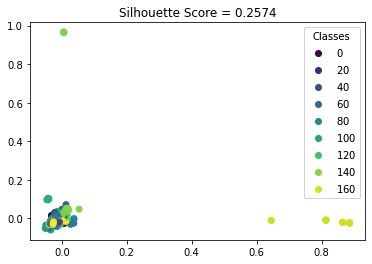

Clustering trained in 1.9255061149597168 seconds
------------------------------------------------------

AgglomerativeClustering()


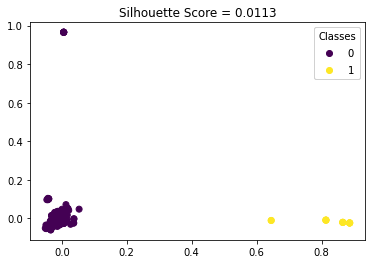

Clustering trained in 4.031599283218384 seconds
------------------------------------------------------

DBSCAN()


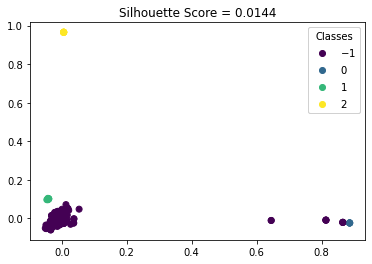

Clustering trained in 0.4995236396789551 seconds
------------------------------------------------------

MiniBatchKMeans(n_clusters=3, random_state=1)


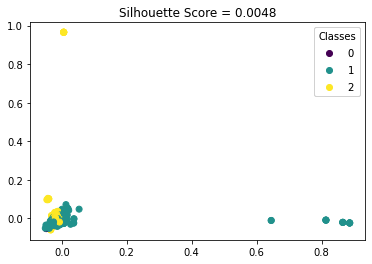

Clustering trained in 1.320007085800171 seconds
------------------------------------------------------



In [33]:
# test multiple algos:
import pandas as pd
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, AgglomerativeClustering, DBSCAN, MiniBatchKMeans
n_clusters = 3
algos = [
    KMeans(n_clusters=n_clusters),
    MeanShift(),
    AffinityPropagation(damping=0.6),
    AgglomerativeClustering(),
    DBSCAN(),
    MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state)
]

results = pd.DataFrame()
for alg in algos:
    cluster_report(alg)
    results[alg.__class__.__name__] = alg.labels_

# Save Results

from src.data.DBConnection import DBConnection
db = DBConnection()
results.to_sql("results", db.conn, if_exists='replace', index_label='id')

Using PCA does not seem to be an effective method of visualizing this data.
